# 0. Initialize

## 0.1. Import Libraries

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt

## 0.2. DEFINE VARIABLES 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/My Drive/412-Project/'

ROUND = 3 # This project will have 3 rounds of predictions: 1,2,3
STUDENT_ID = '26270'
PROJECT_CODE = 'CS4125eb2153b3d78' # Same code for the annotation eg. CS412xxxxx

Mounted at /content/drive


## 0.3. Read Training & Evaluation Data

### 0.3.1. Get the labels for tweets

In [ ]:
trainingTweetDf = pd.read_csv('{}training-tweet.csv'.format(DATA_PATH))
#trainingTweetDf = pd.read_csv('training-tweet.csv', dtype={'tweet_id': str, 'isPolitical': str})
trainingTweetDf

,tweet_id,isPolitical
0,1418828259614236672,No
1,1424439289753083911,No
2,1354305766644199427,Yes
3,1438890637282193408,Yes
4,1397543048452591616,No
...,...,...
2995,1416144676990722053,Yes
2996,1466793383788220421,Yes
2997,1448350353439744003,Yes
2998,1423327989044072453,Yes


In [ ]:
trainingTweetDf.isPolitical.value_counts()

No     1509
Yes    1491
Name: isPolitical, dtype: int64

### 0.3.2. Get the labels for users

In [ ]:
trainingUserDf = pd.read_csv('{}training-user.csv'.format(DATA_PATH))
#trainingUserDf = pd.read_csv('training-user.csv')
trainingUserDf

,screen_name,isBot
0,faracyaziyor,No
1,elifgibirt,No
2,buocguldurdu,No
3,__baba1yaga_,No
4,hakanyilmazcebi,No
...,...,...
2995,kupakralicesi53,No
2996,muhamme44063672,No
2997,galaopta,Not sure
2998,hygea0,No


In [ ]:
trainingUserDf.isBot.value_counts()

No          2363
Yes          401
Not sure     236
Name: isBot, dtype: int64

### 0.3.3. Expand your dataset with metadata and tweets

In [ ]:
# You can also expand training data by downloading your own labeled datasets following the link
# Download the documents under "Link to training data"

print('http://www.onurvarol.com/AnnotationTwitterTR/reports/report_{}.html'.format(PROJECT_CODE))

http://www.onurvarol.com/AnnotationTwitterTR/reports/report_CS4125eb2153b3d78.html


## 1. Landing Page

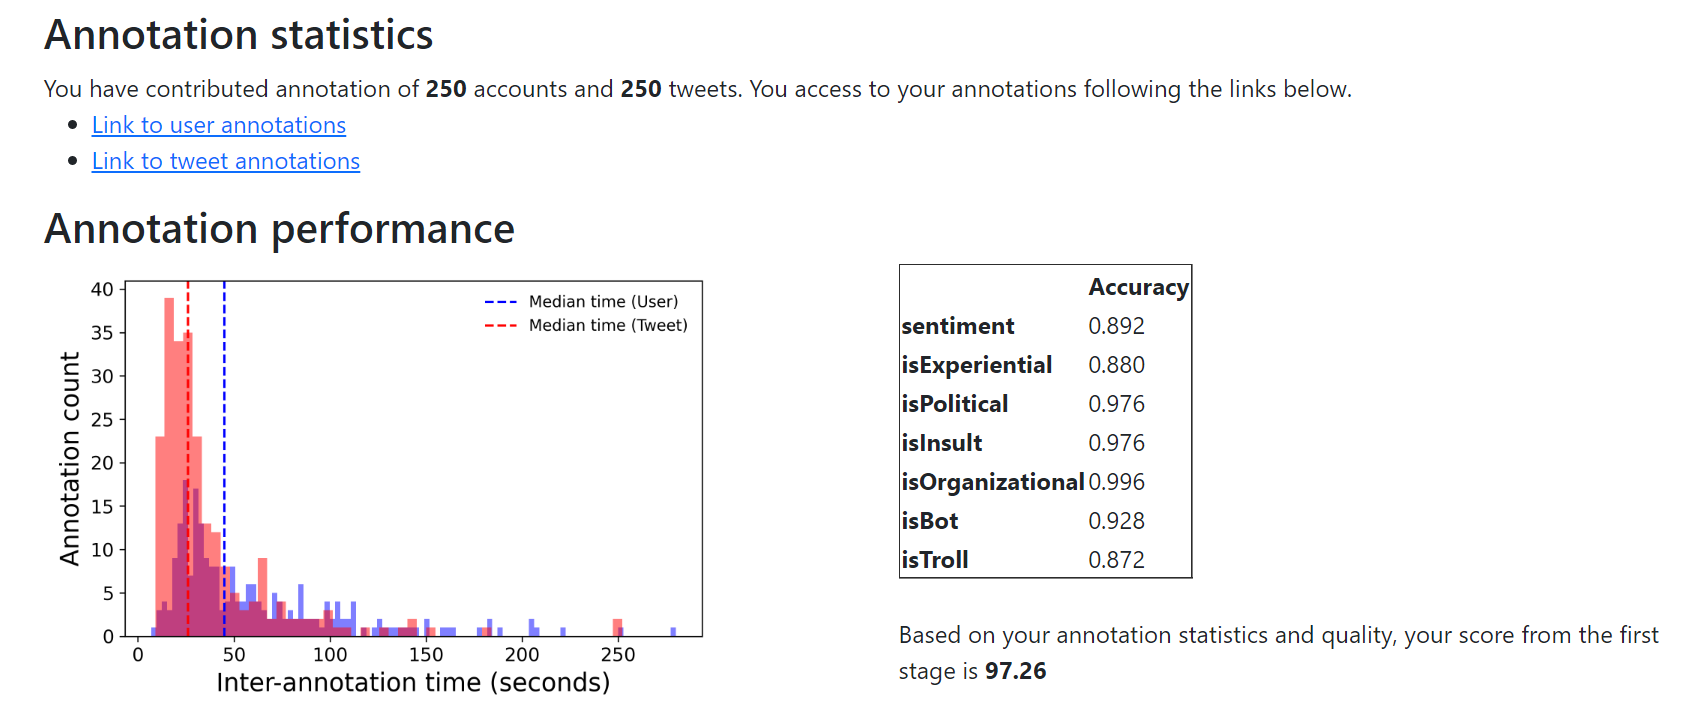

In [ ]:
display.Image("https://i.imgur.com/IHvQHIf.png")

## 2. Link for Downloading Training Data

At the bottom of the page, you will see the **LINK FOR FILES**

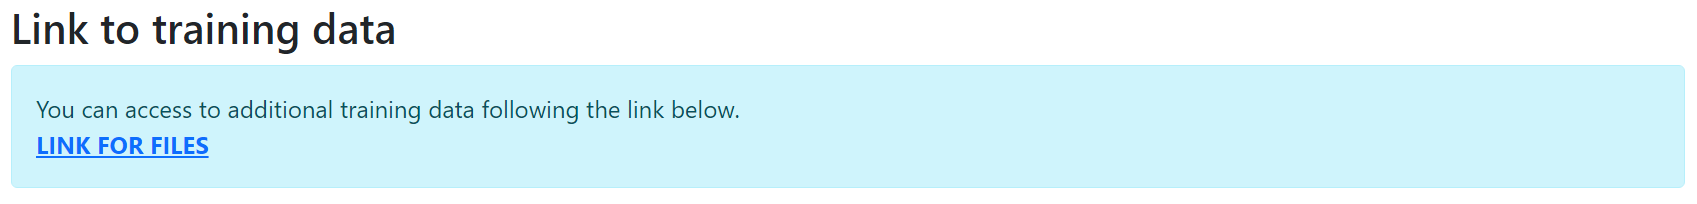

In [ ]:
display.Image("https://i.imgur.com/t19vAjr.png")

## 3. Google Drive

You can download the following project files from Google Drive

- **user_profiles.jsons.gz**: Contains user metadata for bot detection phase of your project
- **user_tweets.jsons.gz**: Contains at most 200 tweets of the above mentioned users'
- **tweet_metadata.jsons.gz**: Contains tweets and their metadata for the political tweet detection of your project

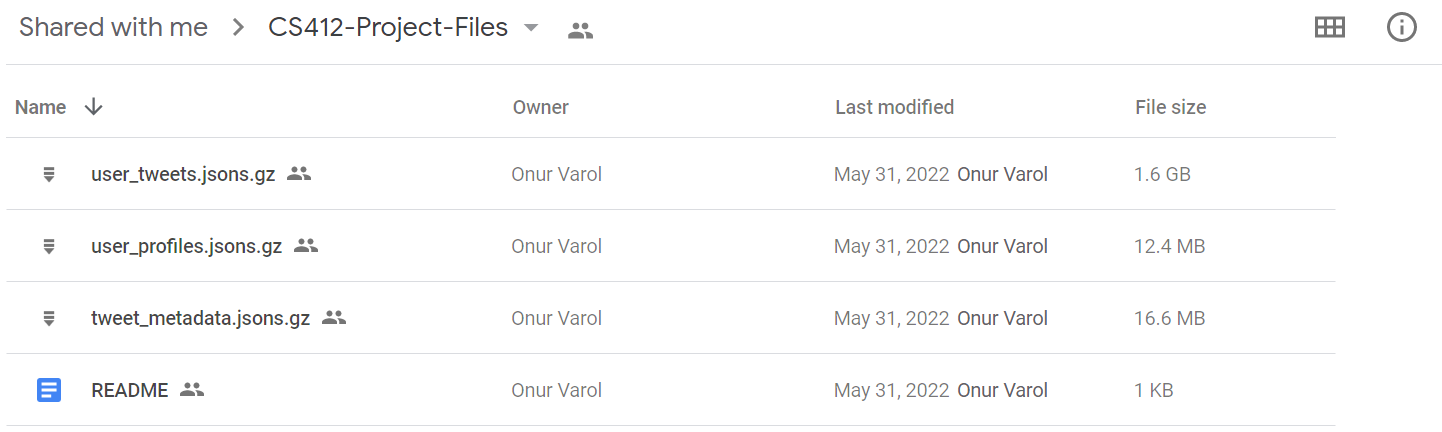

In [ ]:
display.Image("https://i.imgur.com/7FjWPLi.png")

# 1. EXTRACT FEATURES
Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

We expect you to collect more raw data from **tweet_metadata**, **user_profiles** and **user_tweets** files by creating a function as shown in below examples such as *check_if_retweet()* and using it while iterating over data as shown under *Merge Collected Features*.

We also expect you to create new variables as much as you can from the data in order to make your predictions more accurate. For example, you may want to check:

- The tweet sources that a user frequently uses
- Whether the user is a verified account or not

...

to assess whether **a user is a bot or not** and whether **a tweet is political or not**.

In [ ]:
PATH_TO_DOWNLOADED = '/content/drive/My Drive/412-Project/'

## 1.1. Political Tweet Detection
This part stands for the feature extraction of tweets. We start with collecting the raw data from *tweet_metadata*, then use some of them to extract features.

### 1.1.1. Get Raw Data

#### 1.1.1.1. Check if Retweet

In [ ]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = None

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [ ]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [ ]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [ ]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])

    return num_mentions, num_hashtags

#### 1.1.1.5. Get Number of Retweets and Favorites

In [ ]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [ ]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']
    followers = tweet_metadata_line['user']['followers_count']
    friends = tweet_metadata_line['user']['friends_count']
    
    foll_to_all_ratio = 0

    if friends != 0:
        foll_to_all_ratio = followers / (followers + friends)

    verified = tweet_metadata_line['user']['verified']

    if verified == True:
        verified = 1
    else:
        verified = 0

    return id, screen_name, description, followers, friends, foll_to_all_ratio, verified

#### 1.1.1.7 Has media or not

In [ ]:
def has_media(tweet_metadata_line):
    media = None
    hasMedia = 0

    try:
        media = tweet_metadata_line['entities']['media']

        if media != None:
            hasMedia = 1

    except:
        pass

    return hasMedia

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [ ]:
def check_political_ent(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['meral_aksener', 'kilicdarogluk', 'vekilince', 'RTErdogan', 'MevlutCavusoglu', 'umitozdag',
                        'ataturk', 'turkey', 'turkiye', 'biden', 'president', 'erdogan', 'rt', 'millet', 'fahrettin', 'koca',
                        'akp', 'chp', 'akparti', 'imamoglu', 'haber']
    
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower().replace(" ", "")]
    number_entities = len(entities_in_text)

    return number_entities

#### 1.1.2.2. Number of total interactions

In [ ]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count
    
    return total_num_interactions

#### 1.1.2.3. If user description has political entities or not

In [ ]:
def check_user_desc_pol_ent(tweet_metadata_line):
    
    #print(type(tweet_metadata_line['user']['description']))

    if tweet_metadata_line['user']['description'] == '':
        return 0   

    desc = tweet_metadata_line['user']['description'].lower().replace(" ", "")
    
    list_of_entities = ['meral_aksener', 'kilicdarogluk', 'vekilince', 'RTErdogan', 'MevlutCavusoglu', 'umitozdag',
                        'ataturk', 'turkey', 'turkiye', 'biden', 'president', 'erdogan', 'rt', 'millet', 'fahrettin', 'koca',
                        'akp', 'chp', 'akparti', 'imamoglu', 'haber']

    for ent in list_of_entities:
        if ent in desc:
            return 1
    
    return 0

#### 1.1.2.4 Get retweet features if it exists

In [ ]:
def get_retweet_info(tweet_metadata_line):
    retweet_text = None
    num_pol_ent_retweet = 0
    is_retweet_user_desc_pol_ent = 0
    retweet_total_interactions = 0
    retweet_user_foll_to_all_ratio = 0
    retweet_user_verified = 0
    retweet_num_hashtags = 0
    retweet_num_mentions = 0
    tweet_retweet_hashtags_match = 0
    retweet_media = None
    retweet_has_media = 0
    
    try:
        tweet_metadata_line['retweeted_status']
        
        retweet_text = tweet_metadata_line['retweeted_status']['text']
        num_pol_ent_retweet = check_political_ent(retweet_text)
        
        list_of_entities = ['meral_aksener', 'kilicdarogluk', 'vekilince', 'RTErdogan', 'MevlutCavusoglu', 'umitozdag',
                            'ataturk', 'turkey', 'turkiye', 'biden', 'president', 'erdogan', 'rt', 'millet', 'fahrettin', 'koca',
                            'akp', 'chp', 'akparti', 'imamoglu', 'haber']

        retweet_user = tweet_metadata_line['retweeted_status']['user']
        retweet_user_desc = retweet_user['description'].lower().replace(" ", "")

        for ent in list_of_entities:
            if ent in retweet_user_desc:
                is_retweet_user_desc_pol_ent = 1

        retweet_total_interactions = tweet_metadata_line['retweeted_status']['retweet_count'] + tweet_metadata_line['retweeted_status']['favorite_count']
        retweet_user_followers = tweet_metadata_line['retweeted_status']['user']['followers_count']
        retweet_user_friends = tweet_metadata_line['retweeted_status']['user']['friends_count']
        
        if retweet_user_friends != 0:
            retweet_user_foll_to_all_ratio = retweet_user_followers/ (retweet_user_followers + retweet_user_friends)

        retweet_user_verified = tweet_metadata_line['retweeted_status']['user']['verified']

        if retweet_user_verified == True:
            retweet_user_verified = 1
        else:
            retweet_user_verified = 0

        retweet_num_hashtags = len(tweet_metadata_line['retweeted_status']['entities']['hashtags'])
        retweet_num_mentions = len(tweet_metadata_line['retweeted_status']['entities']['user_mentions'])

        tweet_hashtags = tweet_metadata_line['entities']['hashtags']
        retweet_hashtags = tweet_metadata_line['retweeted_status']['entities']['hashtags']

        for ht in retweet_hashtags:
            if ht in tweet_hashtags:
                tweet_retweet_hashtags_match += 1

        retweet_media = tweet_metadata_line['retweeted_status']['entities']['media']

        if retweet_media != None:
            retweet_has_media = 1
    except:
        pass

    return retweet_text, num_pol_ent_retweet, is_retweet_user_desc_pol_ent, retweet_total_interactions, retweet_user_foll_to_all_ratio, retweet_user_verified, retweet_num_hashtags, retweet_num_mentions, tweet_retweet_hashtags_match, retweet_has_media

### 1.1.3. Collect data using the functions above and transform into a Pandas DataFrame

In [ ]:
dfPolitical = {'tweet_id':[],
              'is_retweet':[],
              'retweet_text': [],
              'retweet_has_media': [],
              'num_political_entities_retweet': [],
              'is_retweet_user_desc_pol_ent':[],
              'retweet_num_mentions': [],
              'retweet_num_hashtags': [],
              'tweet_retweet_hashtags_match': [],
              'retweet_total_interactions': [],
              'retweeted_username':[],
              'retweet_user_foll_to_all_ratio': [],
              'retweet_user_verified': [],
              'tweet_text':[],
              'tweet_has_media': [],
              'tweet_num_mentions':[],
              'tweet_num_hashtags':[],
              'tweet_retweet_count':[],
              'tweet_favorite_count':[],
              'tweet_total_interactions':[],
              'num_political_entities_tweet':[],
              'user_id':[],
              'user_screen_name':[],
              'user_description':[],
              'is_user_desc_pol_ent':[],
              'user_followers': [],
              'user_friends': [],
              'user_foll_to_all_ratio': [],
              'user_verified': []}

with gzip.open(f"{PATH_TO_DOWNLOADED}tweet_metadata.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        # raw data:
        id_str = get_tweet_id(line)
        is_retweet, retweeted_username = check_if_retweet(line)
        text = get_tweet_text(line)
        tweet_num_mentions, tweet_num_hashtags = get_number_mentions_hashtags(line)
        tweet_retweet_count, tweet_favorite_count = get_number_retweets_favorites(line)
        user_id_str, screen_name, user_description, user_followers, user_friends, user_foll_to_all_ratio, user_verified = get_user_info(line)
        tweet_has_media = has_media(line)

        # manually crafted data:
        is_user_desc_pol_ent = check_user_desc_pol_ent(line)
        num_political_entities = check_political_ent(text)
        tweet_total_num_interactions = total_interactions(tweet_retweet_count, tweet_favorite_count)
        retweet_text, num_pol_ent_retweet, is_retweet_user_desc_pol_ent, retweet_total_interactions, retweet_user_foll_to_all_ratio, retweet_user_verified, retweet_num_mentions, retweet_num_hashtags, tweet_retweet_hashtags_match, retweet_has_media = get_retweet_info(line)
        
        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweet_text'].append(retweet_text)
        dfPolitical['retweet_has_media'].append(retweet_has_media)
        dfPolitical['num_political_entities_retweet'].append(num_pol_ent_retweet)
        dfPolitical['is_retweet_user_desc_pol_ent'].append(is_retweet_user_desc_pol_ent)
        dfPolitical['retweet_num_mentions'].append(retweet_num_mentions)
        dfPolitical['retweet_num_hashtags'].append(retweet_num_hashtags)
        dfPolitical['tweet_retweet_hashtags_match'].append(tweet_retweet_hashtags_match)
        dfPolitical['retweet_total_interactions'].append(retweet_total_interactions)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['retweet_user_foll_to_all_ratio'].append(retweet_user_foll_to_all_ratio)
        dfPolitical['retweet_user_verified'].append(retweet_user_verified)
        dfPolitical['tweet_text'].append(text)
        dfPolitical['tweet_has_media'].append(tweet_has_media)
        dfPolitical['tweet_num_mentions'].append(tweet_num_mentions)
        dfPolitical['tweet_num_hashtags'].append(tweet_num_hashtags)
        dfPolitical['tweet_retweet_count'].append(tweet_retweet_count)
        dfPolitical['tweet_favorite_count'].append(tweet_favorite_count)
        dfPolitical['tweet_total_interactions'].append(tweet_total_num_interactions)
        dfPolitical['num_political_entities_tweet'].append(num_political_entities)
        dfPolitical['user_id'].append(user_id_str)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(user_description)
        dfPolitical['is_user_desc_pol_ent'].append(is_user_desc_pol_ent)
        dfPolitical['user_followers'].append(user_followers)
        dfPolitical['user_friends'].append(user_friends)
        dfPolitical['user_foll_to_all_ratio'].append(user_foll_to_all_ratio)
        dfPolitical['user_verified'].append(user_verified)
        

In [ ]:
dfPolitical = pd.DataFrame(dfPolitical)

## 1.2. From Users

### 1.2.1. Get user metadata from user_profiles.jsons.gz

#### 1.2.1.1. Get user info metadata

In [ ]:
from datetime import datetime

def get_days_elapsed(datestr):
    datestr = datestr[datestr.find(' ') + 1:]
    plusIndex = datestr.find('+')
    nextspaceIndex = datestr.find(' ', plusIndex)

    datestr = datestr[0:plusIndex] + datestr[nextspaceIndex + 1: ]

    date = datetime.strptime(datestr, '%b %d %H:%M:%S %Y')
    dateToday = datetime.today()

    timeElapsed = dateToday - date

    return int(timeElapsed.days)

In [ ]:
def status_per_day(statusCount, days):
    return statusCount / days

In [ ]:
def favourites_per_day(favoriteCount, days):
    return favoriteCount / days

In [ ]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']
    user_verified = user_metadata_line['verified']

    if user_verified == True:
        user_verified = 1
    else: 
        user_verified = 0
        
    user_profile_image = user_metadata_line['default_profile_image']
    user_status_count = user_metadata_line['statuses_count']
    user_favourites_count = user_metadata_line['favourites_count']
    user_created_at = user_metadata_line['created_at']

    days_elapsed = get_days_elapsed(user_created_at)

    user_status_per_day = status_per_day(user_status_count, days_elapsed)
    user_favourites_per_day = favourites_per_day(user_favourites_count, days_elapsed)

    if user_profile_image == False:
        user_profile_image = 1
    else:
        user_profile_image = 0

    user_screen_name_digits = 0
    digits = '0123456789'
    for digit in digits:
        if digit in user_screen_name:
            user_screen_name_digits += 1
    
    dictionary = {'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 'user_location':user_location,
     'user_description':user_description, 'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count,
     'user_screen_name_digits':user_screen_name_digits,'user_verified':user_verified,'user_status_per_day':user_status_per_day,
     'user_favourites_per_day':user_favourites_per_day, 'user_status_count':user_status_count,'user_favourites_count': user_favourites_count}

    return dictionary

#### 1.2.1.2. Get followers/(followers+friends) ratio

In [ ]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.3. Get description length

In [ ]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len

#### 1.2.1.6. Reading data into Pandas dataframe

In [ ]:
dfBot = {'user_id':[],
         'user_name':[],
         'user_screen_name':[],
         'user_screen_name_digits':[], 
         'user_location':[],
         'user_description':[],
         'user_followers_count':[],
         'user_friends_count':[],
         'description_len':[],
         'followers_to_all_ratio':[],
         'user_verified':[],
         'user_screen_name_digits':[],
         'user_status_per_day':[],
         'user_favourites_per_day':[],
         'user_status_count':[],
         'user_favourites_count':[]}

with gzip.open(f"{PATH_TO_DOWNLOADED}user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)
        
        # manually crafted data:
        description_len = get_desc_len(dictionary['user_description'])
        dfBot['description_len'].append(description_len)
        
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], 
                                                      dictionary['user_friends_count'])

        dfBot['followers_to_all_ratio'].append(followers_all_ratio)

In [ ]:
dfBot = pd.DataFrame(dfBot)
dfBot

,user_id,user_name,user_screen_name,user_screen_name_digits,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,user_verified,user_status_per_day,user_favourites_per_day,user_status_count,user_favourites_count
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,0,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,11.022013,9.358491,10515,8928
1,912738858437050369,AdnanToprak,adnantoprak46,2,Türkiye,,7527,6755,0,0.527027,0,0.972879,189.375072,1686,328187
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,0,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,0,9.225677,24.272150,27594,72598
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,0,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0,6.288554,4.195796,27525,18365
4,1349294559797370881,Muti_79,muti_79,2,"Ankara, Türkiye",,3866,3937,0,0.495450,0,135.867675,326.659735,71874,172803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,0,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,1,2.119391,0.042509,8077,162
31817,1246020601996816385,tuncay,tuncayyilmz,0,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0,8.796069,30.939803,7160,25185
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,0,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0,2.859439,0.023699,10497,87
31819,356064164,Show TV,showtv,0,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,1,24.289892,0.949332,96358,3766


### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of retweets to all tweets

In [ ]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return retweet_total_ratio

#### 1.2.2.2. Check median number of favorites

In [ ]:
def get_median_number_favorites(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])

    return num_median_favorites

#### 1.2.2.4. Get number of tweets

In [ ]:
def get_number_tweets(line):
    #print(len(line['tweets']))
    return len(line['tweets'])
    #for tweet in line['tweets']:
        #return len(tweet)

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [ ]:
dfBotTweets = {'user_id':[],
               'retweet_total_ratio':[],
               'num_median_favorites':[],
               'num_of_tweets':[]}

i = 0

with gzip.open(f"{PATH_TO_DOWNLOADED}user_tweets.jsons.gz", "rb") as f:
    for line in f:

        line = json.loads(line)
        
        user_id = line['user_id']
        dfBotTweets['user_id'].append(user_id)
        
        retweet_total_ratio = get_retweet_tweet_ratio(line)
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        
        num_median_favorites = get_median_number_favorites(line)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)

        num_of_tweets = get_number_tweets(line)
        dfBotTweets['num_of_tweets'].append(num_of_tweets)
        i += 1
        
        if i % 5000 == 0:
            print(i)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5000
10000
15000
20000
25000


In [ ]:
dfBotTweets = pd.DataFrame(dfBotTweets)
dfBotTweets

,user_id,retweet_total_ratio,num_median_favorites,num_of_tweets
0,1044821071,0.090000,57.0,200
1,1086355147,0.172973,10.0,185
2,205625453,0.000000,9.0,200
3,1382717948092157953,0.356784,0.0,199
4,1302055645307375618,0.646154,0.0,195
...,...,...,...,...
29901,1865050056,0.890411,0.0,73
29902,1336329028324577281,0.783920,0.0,199
29903,1214219054329675777,0.970588,0.0,170
29904,310390437,0.875000,0.0,200


**bold text**### 1.2.3. Merge dfBot and dfBotTweets

In [ ]:
dfBotAll = dfBot.merge(dfBotTweets,
                       how='left')

dfBotAll[['retweet_total_ratio', 'num_median_favorites']] = dfBotAll[['retweet_total_ratio', 'num_median_favorites']].fillna(0)

dfBotAll

,user_id,user_name,user_screen_name,user_screen_name_digits,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,user_verified,user_status_per_day,user_favourites_per_day,user_status_count,user_favourites_count,retweet_total_ratio,num_median_favorites,num_of_tweets
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,0,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,11.022013,9.358491,10515,8928,0.060,1.0,200.0
1,912738858437050369,AdnanToprak,adnantoprak46,2,Türkiye,,7527,6755,0,0.527027,0,0.972879,189.375072,1686,328187,0.200,107.0,200.0
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,0,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,0,9.225677,24.272150,27594,72598,0.230,1.0,200.0
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,0,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0,6.288554,4.195796,27525,18365,0.000,0.0,NaN
4,1349294559797370881,Muti_79,muti_79,2,"Ankara, Türkiye",,3866,3937,0,0.495450,0,135.867675,326.659735,71874,172803,1.000,0.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,0,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,1,2.119391,0.042509,8077,162,0.735,0.0,200.0
31817,1246020601996816385,tuncay,tuncayyilmz,0,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0,8.796069,30.939803,7160,25185,0.020,1.0,200.0
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,0,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0,2.859439,0.023699,10497,87,0.000,24.0,200.0
31819,356064164,Show TV,showtv,0,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,1,24.289892,0.949332,96358,3766,0.000,76.5,200.0


# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

### 2.1.1. Merge dfPolitical data with labels

In [ ]:
dfPoliticalInt = dfPolitical.astype({'tweet_id' : 'int64'})

In [ ]:
dfPoliticalAll_train = dfPoliticalInt.merge(trainingTweetDf,
                                         on='tweet_id')

### 2.1.2. Separate X and y values
We only use 3 features here to create a baseline model. However, it is not enough to get good results.

In [ ]:
politicalMap = {'Yes': 1.0, 'No': 0.0}

dfPoliticalAll_train['isPolitical'] = dfPoliticalAll_train['isPolitical'].replace(politicalMap)

#### 2.1.2.1 Feature selection

(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5]), <a list of 12 Text major ticklabel objects>)

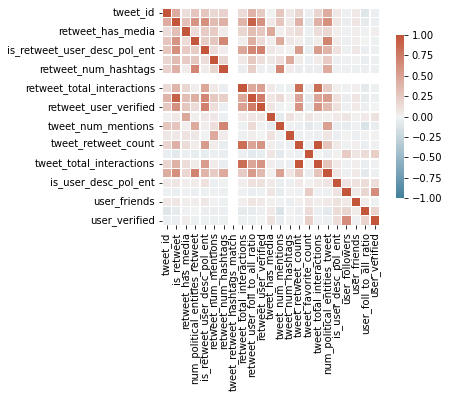

In [ ]:
import seaborn as sns

# Define a nice color map for our heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
        data=dfPoliticalAll_train.drop(columns=['isPolitical']).corr(),  # our correlation matrix
        linewidths=0.3,  # the width of lines separating the matrix squares
        square=True,   # enforce 1:1 ratios among correlation cells
        cmap=cmap,  # use the color map we defined above
        vmax=1,  # define the max of our correlation scale
        vmin=-1, # define the min of our correlation scale
        center=0,  # The value at which the color map is centered about (white)
        cbar_kws={"shrink": .75}  # shrink the scale a bit
    )
# adjust y-axis ticks for legibility
plt.yticks(rotation=0)  

In [ ]:
#X = dfPoliticalAll_train[['num_political_entities','total_interactions','num_hashtags', 'is_retweet', 'is_user_desc_pol_ent', 'num_retweets', 'num_mentions']]
#X = dfPoliticalAll_train[['is_retweet', 'num_political_entities_retweet', 'retweet_has_media', 'retweet_num_mentions', 'retweet_num_hashtags', 'retweet_total_interactions',
#                          'retweet_user_foll_to_fri_ratio', 'retweet_user_verified', 'tweet_has_media', 'tweet_num_mentions', 'tweet_num_hashtags',
#                          'tweet_total_interactions', 'num_political_entities_tweet', 'is_user_desc_pol_ent', 'user_foll_to_fri_ratio', 'user_verified']]
#X = dfPoliticalAll_train[['num_political_entities_retweet', 'retweet_has_media', 'retweet_num_hashtags', 'retweet_total_interactions', 'retweet_user_foll_to_all_ratio',
#                          'retweet_user_verified', 'tweet_has_media', 'tweet_num_mentions', 'tweet_num_hashtags',
#                          'tweet_total_interactions', 'num_political_entities_tweet', 'is_user_desc_pol_ent', 'user_foll_to_all_ratio', 'user_verified']]
X = dfPoliticalAll_train[['num_political_entities_retweet', 'retweet_num_hashtags',
                          'retweet_has_media', 'tweet_num_hashtags', 'retweet_total_interactions',
                          'num_political_entities_tweet', 'is_user_desc_pol_ent',
                          'user_foll_to_all_ratio', 'retweet_user_verified']]
#X = dfPoliticalAll_train[['num_political_entities', 'tweet_id', 'is_retweet', 'num_mentions', 'num_retweets', 'num_hashtags', 'num_favorites', 'is_user_desc_pol_ent', 'total_interactions']]
y = dfPoliticalAll_train['isPolitical']

### 2.1.3. Train - validation split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

### 2.1.4. Train the model

Here, you may use different models such as neural networks, XGBoost, AdaBoost, RandomForest, Linear Regression, Logistic Regression etc. to see which model does the best. Also, you can use grid_search_cv() or a basic for loop to optimize the hyperparameters of your model.

#### 2.1.4.1 Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

# create an instance
dtr_political = DecisionTreeRegressor()

# fit your model
dtr_political.fit(X_train, y_train)

# make predictions
dtr_preds = dtr_political.predict(X_valid)

dtr_error = mean_squared_error(y_valid, dtr_preds)
print("Testing mean squared error = %.5f%%" % (dtr_error * 100))

Testing mean squared error = 28.84593%


#### 2.1.4.2 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error

lr_political = LogisticRegression()
lr_political.fit(X_train, y_train)

lr_preds = lr_political.predict(X_valid)

#print("Logistic Regression Results:")
#print("Precision:", precision_score(y_valid,y_pred_valid_lr))
#print("Recall:", recall_score(y_valid,y_pred_valid_lr))
#print("F1 Score:", f1_score(y_valid,y_pred_valid_lr))
#print("Accuracy Score:",accuracy_score(y_valid,y_pred_valid_lr))
#print("Confusion matrix:\n",confusion_matrix(y_valid,y_pred_valid_lr))
lr_error = mean_squared_error(y_valid, lr_preds)
print("Testing mean squared error = %.5f%%" % (lr_error * 100))

Testing mean squared error = 23.53535%


#### 2.1.4.3 Random Forest

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf_political = RandomForestRegressor(oob_score = True, max_features = 9)
rf_political.fit(X_train, y_train)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(rf_political, X_valid, y_valid, cv=cv, n_jobs=-1)
#print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
#print(rf_political.oob_score_)

rf_preds = rf_political.predict(X_valid)
rf_error = mean_squared_error(y_valid, rf_preds)
print("Testing mean squared error = %.5f%%" % (rf_error * 100))

Testing mean squared error = 20.61174%


#### 2.1.4.4 K-Nearest Neighbours

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# initialize the values of k:
param_grid = {'n_neighbors':[1,3,5,7,9,11,13,15,17,19]}
knn = KNeighborsRegressor()
# loop over values of k for the k-Nearest Neighbor classifier
grid = GridSearchCV(knn,
                    param_grid, 
                    cv=5,
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

knn_political = grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
# Predict the labels of the test data
knn_preds = knn_political.predict(X_valid)

# Calculate the accuracy given the true labels and prediction of test data

knn_error = mean_squared_error(y_valid, knn_preds)
#TestF1Score = f1_score(y_valid, predictions)

print("Testing mean squared error = %.5f%%" % (knn_error * 100))
#print("Testing F-1 Score = %.5f%%" % (TestF1Score * 100))

Testing mean squared error = 16.67366%


#### 2.1.4.5 CNN

In [ ]:
from sklearn.preprocessing import MinMaxScaler

dfCNN = dfPoliticalAll_train.drop(columns=['tweet_id', 'retweet_text', 'retweeted_username', 'tweet_text', 'user_id', 'user_screen_name', 'user_description'])

#dfCNN = dfCNN[['num_political_entities_retweet', 'retweet_has_media', 'retweet_num_hashtags', 'retweet_total_interactions', 'retweet_user_foll_to_all_ratio',
#               'retweet_user_verified', 'tweet_has_media', 'tweet_num_mentions', 'tweet_num_hashtags',
#               'tweet_total_interactions', 'num_political_entities_tweet', 'is_user_desc_pol_ent', 'user_foll_to_all_ratio', 'user_verified', 'isPolitical']]

dfCNN = dfCNN[['num_political_entities_retweet', 'retweet_num_hashtags',
               'retweet_has_media', 'tweet_num_hashtags', 'retweet_total_interactions',
               'num_political_entities_tweet', 'is_user_desc_pol_ent',
               'user_foll_to_all_ratio', 'retweet_user_verified', 'isPolitical']]

msc = MinMaxScaler(feature_range=(0, 1))
scaled_train = msc.fit_transform(dfCNN)
scaled_train_df = pd.DataFrame(scaled_train, columns=dfCNN.columns.values)

In [ ]:
X_CNN = scaled_train_df.drop(columns=['isPolitical'])

# Define y:
y_CNN = scaled_train_df['isPolitical']

# Split 90-10
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_CNN, y_CNN, test_size=0.1, random_state=42)

X_train_CNN = X_train_df.values
y_train_CNN = y_train_df.values
X_val_CNN = X_val_df.values
y_val_CNN = y_val_df.values

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam

min_rates = []
learning_rates = [0.1, 0.09, 0.07, 0.03, 0.01, 0.001]
for i in range (3):
  print('ITERATION:', i + 1)
  min_score = 0
  min_rate = 0
  count = 0
  for rate in learning_rates:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, activation='relu', name='hiddenLayer-1'))
    #model.add(tf.keras.layers.Dense(25, activation='relu', name='hiddenLayer-2'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=rate)
    model.compile(loss='mean_squared_error', optimizer=opt)
    model.fit(X_train_CNN, y_train_CNN, batch_size=64, epochs=30, verbose=0)
    score = model.evaluate(X_val_CNN, y_val_CNN, verbose=0)
    if count == 0:
      min_score = score
      min_rate = rate
    count += 1
    if score < min_score:
      min_score = score
      min_rate = rate
    print("Prediction loss with learning rate ", rate, ': ', score, sep='')
  print("Minimum loss was:", min_score, 'with learning rate:', min_rate, '\n')
  min_rates.append(min_rate)

max_occur_rate = 0
for rate in min_rates:
  if min_rates.count(rate) > min_rates.count(max_occur_rate):
    max_occur_rate = rate

print("The best learning rate is:", max_occur_rate)

ITERATION: 1
Prediction loss with learning rate 0.1: 0.1590770035982132
Prediction loss with learning rate 0.09: 0.16444367170333862
Prediction loss with learning rate 0.07: 0.16331453621387482
Prediction loss with learning rate 0.03: 0.16561312973499298
Prediction loss with learning rate 0.01: 0.15806443989276886
Prediction loss with learning rate 0.001: 0.16248512268066406
Minimum loss was: 0.15806443989276886 with learning rate: 0.01 

ITERATION: 2
Prediction loss with learning rate 0.1: 0.1598774790763855
Prediction loss with learning rate 0.09: 0.15894798934459686
Prediction loss with learning rate 0.07: 0.18484821915626526
Prediction loss with learning rate 0.03: 0.1599651426076889
Prediction loss with learning rate 0.01: 0.15835432708263397
Prediction loss with learning rate 0.001: 0.16233262419700623
Minimum loss was: 0.15835432708263397 with learning rate: 0.01 

ITERATION: 3
Prediction loss with learning rate 0.1: 0.16423359513282776
Prediction loss with learning rate 0.09: 0

In [ ]:
cnn_political = tf.keras.Sequential()
cnn_political.add(tf.keras.layers.Dense(128, activation='relu', name='hiddenLayer-1'))
#cnn_political.add(tf.keras.layers.Dense(25, activation='relu', name='hiddenLayer-2'))
cnn_political.add(tf.keras.layers.Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=max_occur_rate)
cnn_political.compile(loss='mean_squared_error', optimizer=opt, metrics=['acc'])
cnn_political.fit(X_train_CNN, y_train_CNN, batch_size=64, epochs=30, verbose=0)
score = cnn_political.evaluate(X_val_CNN, y_val_CNN, verbose=0)
print("Testing mean squared error = %.5f%%" % (score[0] * 100))

Testing mean squared error = 15.73307%


## 2.2. Bot Detection

### 2.2.1. Merge dfBotAll data with labels

In [ ]:
dfBotAll.user_screen_name = dfBotAll.user_screen_name.str.lower()

In [ ]:
dfBotAll_train = dfBotAll.merge(trainingUserDf,
                               left_on='user_screen_name',
                               right_on='screen_name')

botMap = {'Yes': 1.0, 'No': 0.0, 'Not sure': 0.5}
dfBotAll_train['isBot'] = dfBotAll_train['isBot'].replace(botMap)
dfBotAll_train['num_of_tweets'] = dfBotAll_train['num_of_tweets'].fillna(0)

In [ ]:
dfBotAll

,user_id,user_name,user_screen_name,user_screen_name_digits,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,user_verified,user_status_per_day,user_favourites_per_day,user_status_count,user_favourites_count,retweet_total_ratio,num_median_favorites,num_of_tweets
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,0,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,11.022013,9.358491,10515,8928,0.060,1.0,200.0
1,912738858437050369,AdnanToprak,adnantoprak46,2,Türkiye,,7527,6755,0,0.527027,0,0.972879,189.375072,1686,328187,0.200,107.0,200.0
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,0,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,0,9.225677,24.272150,27594,72598,0.230,1.0,200.0
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,0,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0,6.288554,4.195796,27525,18365,0.000,0.0,NaN
4,1349294559797370881,Muti_79,muti_79,2,"Ankara, Türkiye",,3866,3937,0,0.495450,0,135.867675,326.659735,71874,172803,1.000,0.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,0,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,1,2.119391,0.042509,8077,162,0.735,0.0,200.0
31817,1246020601996816385,tuncay,tuncayyilmz,0,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0,8.796069,30.939803,7160,25185,0.020,1.0,200.0
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,0,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0,2.859439,0.023699,10497,87,0.000,24.0,200.0
31819,356064164,Show TV,showtv,0,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,1,24.289892,0.949332,96358,3766,0.000,76.5,200.0


In [ ]:
trainingUserDf['isBot'] = trainingUserDf['isBot'].replace(botMap)

In [ ]:
trainingUserDf.isBot.value_counts()

0.0    2363
1.0     401
0.5     236
Name: isBot, dtype: int64

### 2.2.2. Separate X and y values
We use only 4 features here to create a baseline model. However, it is not enough to get good results.

In [ ]:
#X_bot = dfBotAll_train[['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites']]
#X_bot = dfBotAll_train[['user_screen_name_digits', 'user_followers_count', 'user_friends_count', 'description_len', 'followers_to_all_ratio',
#                        'user_verified', 'user_status_per_day', 'user_favourites_per_day', 'user_status_count',
#                        'user_favourites_count', 'retweet_total_ratio', 'num_median_favorites', 'num_of_tweets']]
X_bot = dfBotAll_train[['user_screen_name_digits', 'followers_to_all_ratio',
                        'user_verified', 'user_status_per_day', 'user_status_count',
                        'user_favourites_count', 'retweet_total_ratio']]
y_bot = dfBotAll_train['isBot']

### 2.2.3. Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train_bot, X_valid_bot, y_train_bot, y_valid_bot = train_test_split(X_bot, y_bot, test_size=0.33, random_state=42)

### 2.2.4. Train the model

#### 2.2.4.1 Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

# create an instance
dtr_bot = DecisionTreeRegressor()

# fit your model
dtr_bot.fit(X_train_bot, y_train_bot)

# make predictions
dtr_preds = dtr_bot.predict(X_valid_bot)

# evaluate on validation set
#acc_score = accuracy_score(y_valid, preds)
#confusion = confusion_matrix(y_valid, preds)
dtr_error = mean_squared_error(y_valid_bot, dtr_preds)
print("Testing mean squared error = %.5f%%" % (dtr_error * 100))

Testing mean squared error = 22.42424%


#### 2.2.4.2 Random Forest

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf_bot = RandomForestRegressor(oob_score = True, max_features = 7)
rf_bot.fit(X_train_bot, y_train_bot)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(rf_bot, X_valid, y_valid, cv=cv, n_jobs=-1)
#print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
#print(rf_political.oob_score_)

rf_preds = rf_bot.predict(X_valid_bot)
rf_error = mean_squared_error(y_valid_bot, rf_preds)
print("Testing mean squared error = %.5f%%" % (rf_error * 100))

Testing mean squared error = 11.84181%


#### 2.2.4.3 K-Nearest Neighbours

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# initialize the values of k:
param_grid = {'n_neighbors':[1,3,5,7,9,11,13,15,17,19]}
knn = KNeighborsRegressor()
# loop over values of k for the k-Nearest Neighbor classifier
grid = GridSearchCV(knn,
                    param_grid, 
                    cv=5,
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

knn_bot = grid.fit(X_train_bot, y_train_bot)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
# Predict the labels of the test data
knn_preds = knn_bot.predict(X_valid_bot)

# Calculate the accuracy given the true labels and prediction of test data

knn_error = mean_squared_error(y_valid_bot, knn_preds)
#TestF1Score = f1_score(y_valid, predictions)

print("Testing mean squared error = %.5f%%" % (knn_error * 100))
#print("Testing F-1 Score = %.5f%%" % (TestF1Score * 100))

Testing mean squared error = 13.47701%


#### 2.2.4.4 CNN

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# dfCNN_bot = dfBotAll_train[['user_screen_name_digits', 'user_followers_count', 'user_friends_count', 'description_len', 'followers_to_all_ratio',
#                         'user_verified', 'user_status_per_day', 'user_favourites_per_day', 'user_status_count',
#                         'user_favourites_count', 'retweet_total_ratio', 'num_median_favorites', 'num_of_tweets', 'isBot']]

dfCNN_bot = dfBotAll_train[['user_screen_name_digits', 'followers_to_all_ratio',
                        'user_verified', 'user_status_per_day', 'user_status_count',
                        'user_favourites_count', 'retweet_total_ratio', 'isBot']]

msc = MinMaxScaler(feature_range=(0, 1))
scaled_train_bot = msc.fit_transform(dfCNN_bot)
scaled_train_df_bot = pd.DataFrame(scaled_train_bot, columns=dfCNN_bot.columns.values)

In [ ]:
X_CNN_bot = scaled_train_df_bot.drop(columns=['isBot'])

# Define y:
y_CNN_bot = scaled_train_df_bot['isBot']

# Split 90-10
X_train_df_bot, X_val_df_bot, y_train_df_bot, y_val_df_bot = train_test_split(X_CNN_bot, y_CNN_bot, test_size=0.1, random_state=42)

X_train_CNN_bot = X_train_df_bot.values
y_train_CNN_bot = y_train_df_bot.values
X_val_CNN_bot = X_val_df_bot.values
y_val_CNN_bot = y_val_df_bot.values

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam

min_rates = []
learning_rates = [0.1, 0.09, 0.07, 0.03, 0.01, 0.001]
for i in range (3):
  print('ITERATION:', i + 1)
  min_score = 0
  min_rate = 0
  count = 0
  for rate in learning_rates:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, activation='relu', name='hiddenLayer-1'))
    #model.add(tf.keras.layers.Dense(25, activation='relu', name='hiddenLayer-2'))
    model.add(tf.keras.layers.Dense(1))
    opt = Adam(learning_rate=rate)
    model.compile(loss='mean_squared_error', optimizer=opt)
    model.fit(X_train_CNN_bot, y_train_CNN_bot, batch_size=64, epochs=30, verbose=0)
    score = model.evaluate(X_val_CNN_bot, y_val_CNN_bot, verbose=0)
    if count == 0:
      min_score = score
      min_rate = rate
    count += 1
    if score < min_score:
      min_score = score
      min_rate = rate
    print("Prediction loss with learning rate ", rate, ': ', score, sep='')
  print("Minimum loss was:", min_score, 'with learning rate:', min_rate, '\n')
  min_rates.append(min_rate)

max_occur_rate = 0
for rate in min_rates:
  if min_rates.count(rate) > min_rates.count(max_occur_rate):
    max_occur_rate = rate

print("The best learning rate is:", max_occur_rate)

ITERATION: 1
Prediction loss with learning rate 0.1: 0.1408599317073822
Prediction loss with learning rate 0.09: 0.12380317598581314
Prediction loss with learning rate 0.07: 0.12699539959430695
Prediction loss with learning rate 0.03: 0.12872152030467987
Prediction loss with learning rate 0.01: 0.11786842346191406
Prediction loss with learning rate 0.001: 0.11753518134355545
Minimum loss was: 0.11753518134355545 with learning rate: 0.001 

ITERATION: 2
Prediction loss with learning rate 0.1: 0.13830220699310303
Prediction loss with learning rate 0.09: 0.12077293545007706
Prediction loss with learning rate 0.07: 0.118783138692379
Prediction loss with learning rate 0.03: 0.12070484459400177
Prediction loss with learning rate 0.01: 0.11891442537307739
Prediction loss with learning rate 0.001: 0.1183147057890892
Minimum loss was: 0.1183147057890892 with learning rate: 0.001 

ITERATION: 3
Prediction loss with learning rate 0.1: 0.11994748562574387
Prediction loss with learning rate 0.09: 0

In [ ]:
cnn_bot = tf.keras.Sequential()
cnn_bot.add(tf.keras.layers.Dense(128, activation='relu', name='hiddenLayer-1'))
#cnn_political.add(tf.keras.layers.Dense(25, activation='relu', name='hiddenLayer-2'))
cnn_bot.add(tf.keras.layers.Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=max_occur_rate)
cnn_bot.compile(loss='mean_squared_error', optimizer=opt, metrics=['acc'])
cnn_bot.fit(X_train_CNN_bot, y_train_CNN_bot, batch_size=64, epochs=30, verbose=0)
score = cnn_bot.evaluate(X_val_CNN_bot, y_val_CNN_bot, verbose=0)
print("Testing mean squared error = %.5f%%" % (score[0] * 100))

Testing mean squared error = 12.02727%


# 3. MAKE PREDICTIONS

Here, you will make predictions with the models that you have trained above.

## 3.1. Predictions for Tweets (Political or Not)

In [ ]:
# read the evaluation file as follows
evaluationTweetDf = pd.read_csv('{}evaluation-round3-tweet.csv'.format(DATA_PATH), dtype={0: str}, header=None, names=['tweet_id'])
evaluationTweetDf = evaluationTweetDf.dropna()
evaluationTweetDf

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfPolitical_test = dfPolitical.merge(evaluationTweetDf)

dfCNN2 = dfPolitical_test[['num_political_entities_retweet', 'retweet_num_hashtags',
                          'retweet_has_media', 'tweet_num_hashtags', 'retweet_total_interactions',
                          'num_political_entities_tweet', 'is_user_desc_pol_ent',
                          'user_foll_to_all_ratio', 'retweet_user_verified']]

msc = MinMaxScaler(feature_range=(0, 1))
scaled_train2 = msc.fit_transform(dfCNN2)
scaled_train_df2 = pd.DataFrame(scaled_train2, columns=dfCNN2.columns.values)

# define X as we did above in section (2.x.2. Separate X and y values)
X_final = dfCNN2

# make predictions based on these variables
predictions_political = cnn_political.predict(X_final)

### This part is important! We expect you to return your predictions in the following format:

In [ ]:
modelPredTweet = dict([(x,float(y)) for x,y in zip([*dfPolitical_test.tweet_id], predictions_political)])
modelPredTweet

{'1355218051214553090': 0.18842683732509613,
 '1446578802507780102': 0.17418089509010315,
 '1396859026705629191': 0.14145728945732117,
 '1351058108651630593': 0.19614779949188232,
 '1344910889741393920': 0.14121869206428528,
 '1402216638926163968': 0.9892443418502808,
 '1433340600544342016': 0.1707310974597931,
 '1370134257490870273': 0.1492253690958023,
 '1404914095254654985': 0.12979856133460999,
 '1423390250932518912': 0.1998237520456314,
 '1379103391561973776': 0.1847490668296814,
 '1441887862262321152': 4.0931658418230654e-07,
 '1428477576436125697': 0.22737951576709747,
 '1430964534865547267': 0.23968453705310822,
 '1396099692392591369': 0.1990598887205124,
 '1453457844834025482': 0.1787007451057434,
 '1368522336543137795': 0.9678851962089539,
 '1471136747916562432': 0.9999830722808838,
 '1426676740659814403': 0.1514413058757782,
 '1380989833452093440': 0.24470609426498413,
 '1386220168293101570': 0.16149069368839264,
 '1446955255971856387': 0.16232575476169586,
 '138793254280493

## 3.2. Predictions for Users (Bot or Not)

In [ ]:
evaluationUserDf = pd.read_csv('{}evaluation-round3-user.csv'.format(DATA_PATH), dtype={0: str}, header=None, names=['user_screen_name'])
evaluationUserDf = evaluationUserDf.dropna()

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfBot_test = dfBotAll.merge(evaluationUserDf)

dfBot_test['num_of_tweets'] = dfBot_test['num_of_tweets'].fillna(0)

# define X as we did above in section (2.x.2. Separate X and y values)
X_final = dfBot_test[['user_screen_name_digits', 'followers_to_all_ratio',
                        'user_verified', 'user_status_per_day', 'user_status_count',
                        'user_favourites_count', 'retweet_total_ratio']]

# make predictions based on these variables
predictions_bot = cnn_bot.predict(X_final)

In [ ]:
modelPredUser = dict([(x,float(y)) for x,y in zip([*dfBot_test.user_screen_name], predictions_bot)])
modelPredUser

{'adnantoprak46': 0.0,
 'ay3613': 0.0,
 'hazanguzel': 1.0,
 'sabirsiztr': 0.0,
 'alonedrummer': 1.0,
 'doktoramaaktor': 0.0,
 'canimmbenimm3': 0.0,
 'muneccimsimge': 0.0,
 'koramzeynep': 0.0,
 'rabosscy': 0.0,
 'aykut190720': 0.0,
 'shadowoflower': 0.0,
 'adler16392917': 0.0,
 'alioztoprak06': 0.0,
 'taylankumelii': 1.0,
 'coldkitchen': 0.0,
 'rsrsrs97': 0.0,
 'herseyeloji': 7.377410838671494e-06,
 'eceemsoysal': 0.0,
 'prfbaris': 0.0,
 'emell_zaim': 0.0,
 'seminanurrk': 0.0,
 'viennabjk93': 0.0,
 'neogaymyback': 0.0,
 'av_abdurrahim': 0.0,
 'theinformavore': 0.0,
 'ahmetin93': 0.0,
 'akrepkral1507': 0.0,
 'neselibalkabagi': 0.0,
 'dutal28': 0.0,
 'psychobutlogist': 0.0,
 'whiplashgirl_': 0.0,
 'senihadeyin': 0.0,
 'awwdizzy': 0.0,
 'suleymany4': 0.0,
 'canandrli': 0.0,
 'meloreco_recmel': 0.0,
 'limon99': 0.0,
 'burcusaan': 0.0,
 'bagcebariscan': 0.0,
 'kasimileri_': 0.0,
 'aytacvehbi': 1.0,
 'beyyzasx': 0.0,
 'tasduzgun': 0.0,
 'sibellzeynepp': 0.0,
 'obanioglu': 0.0,
 'fbrepublicorg

# PREPARE SUBMISSION

You will need to submit exact same file produced by using the following code. Any deviation from the desired format willbe marked as 0.

In [ ]:
with open('{}/{}-round{}-tweet.txt'.format(DATA_PATH, STUDENT_ID, ROUND), 'w') as fl:
    fl.write('{} - {}\n'.format(STUDENT_ID, PROJECT_CODE))
    fl.write(json.dumps(modelPredTweet))
    
    
with open('{}/{}-round{}-user.txt'.format(DATA_PATH, STUDENT_ID, ROUND), 'w') as fl:
    fl.write('{} - {}\n'.format(STUDENT_ID, PROJECT_CODE))
    fl.write(json.dumps(modelPredUser))

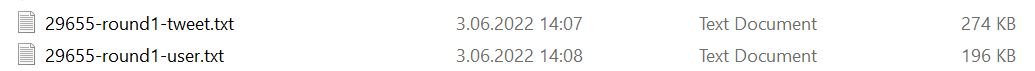

In [ ]:
display.Image("https://i.imgur.com/lcwRsOW.png")

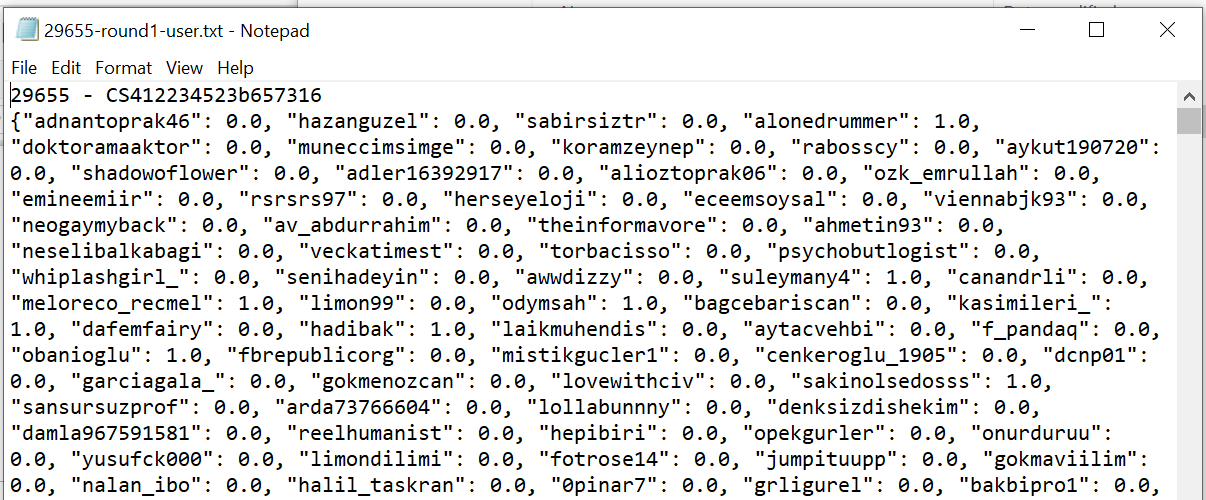

In [ ]:
display.Image("https://i.imgur.com/qfxqgMF.png")

You can check whether you can read your predictions correctly or not:

In [ ]:
with open('{}/{}-round{}-tweet.txt'.format(DATA_PATH, STUDENT_ID, ROUND), 'r') as fl:
    file = fl.read()

student_info = file.split("\n")[0]
predictions = eval(file.split("\n")[1])